# Demo: using group K fold to split training/testing or training/validation datasets


In [16]:
import os
import geopandas as gpd
import pandas as pd 
import numpy as np
import xarray as xr
import rasterio as rio

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold


In [17]:
# plt.rcParams.update({'font.size': 16})
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [18]:
homedir = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/'



# Load data 

In [19]:
''' --------------
Get Shapefiles 
------------------ '''

# measures ice shelves
iceshelf_path_meas = os.path.join(homedir, 'QGis/Quantarctica/Quantarctica3/Glaciology/MEaSUREs Antarctic Boundaries/IceShelf/IceShelf_Antarctica_v02.shp')
iceshelf_poly_meas = gpd.read_file(iceshelf_path_meas)

iceshelf_polygon_gpd = iceshelf_poly_meas.drop(['testField','TYPE'],axis=1)
# # tmp: add check for number of ice shelves..
# iceshelves_in_region_poly = roi_poly.sjoin(iceshelf_polygon_gpd,how='left') 
# len(iceshelves_in_region_poly['index_right'].unique())

### Functions

In [20]:

def make_ais_grid( grid_res):
    xmin, xmax = -3040000, 3040000
    ymin, ymax = -3040000, 3040000
    x_seq = np.arange(xmin, xmax, step=grid_res )
    y_seq = np.arange(ymin, ymax, step=grid_res )

    # ais_dummy = np.ones( (len(x_seq),len(y_seq) ) )
    ais_dummy = np.ones( (len(y_seq),len(x_seq) ) )

    ais_dummy = xr.DataArray(
        # data=np.ones( (len(x_seq),len(y_seq) ) ),
        data=np.ones( (len(y_seq),len(x_seq) ) ),
        dims=["y", "x"],#["x", "y"],
        coords=dict(
            y= y_seq,
            x=x_seq,
            # x=x_seq,
            # y= y_seq,
        ),
        attrs=dict(
            description="DummyAISgrid",
        ),
    ).rio.write_crs(3031)
    return ais_dummy 


# def reprj_regions_to_ais_grid(ais_da, regions_yr_da_list): ## ONLY FOR SINGLE YEAR, or need to do something with 'time' dimension
def reprj_regions_to_ais_grid(ais_da, img_da):
    img_da.rio.write_crs(3031, inplace=True)
    
    # -- reproject (even though same crs) and match grid (extent, resolution and projection)
    img_repr_match = img_da.rio.reproject_match(ais_da,resampling=rio.enums.Resampling.nearest,nodata=np.nan) # need to specify nodata, otherwise fills with (inf) number 1.79769313e+308

    # Update coords
    img_repr_match = img_repr_match.assign_coords({
        "y": ais_da.y,
        "x": ais_da.x,
    })

    return img_repr_match


cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap='magma_r'
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["target-value", "groups"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        # xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


## Load input and target data 

Note: I have Antarctic wide data saved per sector to make my pre-processing life easier. These need to be combined into one dataArray first. If you have Antarctic wide data, you can skip that part. 

Loading netCDFs  data_sector-ASE
Loading netCDFs  data_sector-BSE
Loading netCDFs  data_sector-WS
Loading netCDFs  data_sector-EIS
Loading netCDFs  data_sector-RS
.. Merged to single AIS dataset
.. resolution  (8000.0, 8000.0)m


Text(0.5, 1.0, 'vx')

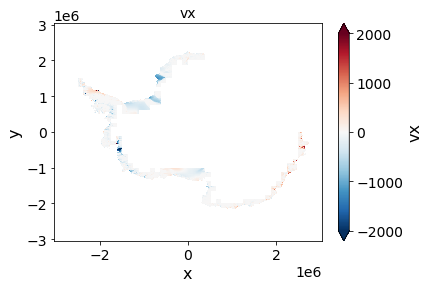

In [21]:
path2data = os.path.join(homedir, 'Data/NERD/data_predictor/data_sector/demo/')

nc_filelist = [('data_sector-ASE_vx_2019.nc', 'data_sector-ASE_vy_2019.nc', 'data_sector-ASE_dmg_2019.nc'),
            ('data_sector-BSE_vx_2019.nc', 'data_sector-BSE_vy_2019.nc', 'data_sector-BSE_dmg_2019.nc'),
            ('data_sector-WS_vx_2019.nc','data_sector-WS_vy_2019.nc','data_sector-WS_dmg_2019.nc'),
            ('data_sector-EIS_vx_2019.nc','data_sector-EIS_vy_2019.nc','data_sector-EIS_dmg_2019.nc'),
            ('data_sector-RS_vx_2019.nc', 'data_sector-RS_vy_2019.nc', 'data_sector-RS_dmg_2019.nc'),
            # ('data_sector-WIS_vx_2019.nc', 'data_sector-WIS_vy_2019.nc')
            ]


''' --------
Option A: Load Antarctic wide data:
------------'''
## If you have multiple netcdfs (one for each variable) for AIS wide, you can load faster with xr.open_mfdataset() 
# region_ds = xr.open_mfdataset( pathlist,  
#                   combine="by_coords", decode_times=True,
#                   data_vars='minimal', 
#                   coords= 'minimal', 
#                   compat='broadcast_equals', #  all values must be equal when variables are broadcast against each other to ensure common dimensions.
#                   )  

''' --------
Option B: Load Antarctic wide data sector by sector:
------------'''
import dask

region_ds_list = []
for filenames_region in nc_filelist: 

    print('Loading netCDFs ', filenames_region[0].split('_vx')[0] )
    
    file_paths = [os.path.join(path2data,file) for file in filenames_region ]
    region_ds = xr.open_mfdataset( file_paths ) # dataset with multiple variables

    ''' --------
    Downsample data so that it is easier to work with for this demo
    And reproject to same AIS-wide grid
    ------------'''

    input_res = region_ds.rio.resolution()[0]
    ksize=20
    with dask.config.set(**{'array.slicing.split_large_chunks': False}): ## accept large chunks; ignore warning
        region_ds = region_ds.coarsen(x=ksize,y=ksize,boundary='pad').mean() # mean downsampling 
        
        ## make sure regular grid is used; and that each region is at the same AIS-grid
        grid_res = ksize*input_res # meter (input was 400m; )
        ais_dummy = make_ais_grid( grid_res)
        region_ds = reprj_regions_to_ais_grid(ais_dummy,region_ds.transpose('time','y','x'))

    region_ds_list.append(region_ds)


'''
Combine grids that (partially) overlap, so xr.combine or xr.merge doesnt work
STEP 1: concatenate (along new dimension to account for overlapping coords)
data_ds = xr.concat(data_list,dim=['y','x'])
STEP 2: merge new dimension 
data_ds = data_ds.max(dim='concat_dim')
'''

data_ds = region_ds_list[0] # initialise merge
for region_ds in region_ds_list[1:]:
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        # step 1: concatenate
        # step 2: flatten the concat dim
        data_ds = xr.concat([data_ds, region_ds],dim=['y','x']).max(dim='concat_dim')

print('.. Merged to single AIS dataset' )
print('.. resolution  {}m'.format(data_ds.rio.resolution()))
data_ds['vx'].sel(time=2019).plot.imshow(vmin=-2000, vmax=2000,cmap='RdBu_r'); plt.title('vx')

## Convert 2D to 1D, and xarray.Dataset to geopandas dataframe

In [22]:

    
''' Clip to iceshelf  '''
iceshelf_polygon_gpd = iceshelf_poly_meas.drop(['testField','TYPE','Area'],axis=1) # drop unnecessary columns; and Area column is not accurate 
data_ds  = data_ds.rio.clip( iceshelf_polygon_gpd.geometry, iceshelf_polygon_gpd.crs, drop=False, invert=False)

''' Aggregate to 1D '''
data_ds_1d = data_ds.stack(samples=['x','y']) # (time, samples)

''' ----------------
Convert to dataFrame
--------------------'''

data_pxs_df = data_ds_1d.to_dataframe() # nested dataframe
# data_pxs_df = data_pxs_df.rename(columns={"x": "x_coord", "y": "y_coord"}) # rename the column so that flattening the multi-index in the next step does not give an error (only relevant for newer pandas version)

# Flatten the nested multi-index to just column values -- automatically generates a 'year' value for every sample
data_pxs_df = data_pxs_df.reset_index(level=['time','x','y']) # 18767504 rows; 

# # Drop spatial ref (has not data acutally) 
data_pxs_df = data_pxs_df.drop(['spatial_ref'],axis=1)


''' ----------------
Drop Nan Values
NB: if you want to unstack your 1D dataframe back to 2D, skip this step
--------------------'''
# Drop rows which contain missing values for the available variables
data_pxs_df.dropna(subset=['dmg', 'vx', 'vy'], thresh=3, inplace=True)


''' ----------------
Add index of corresponding ice shelf to each point (to be used for spatial k-fold CV)
1. Convert dataframe to geopandas dataframe
2. Perform spatialjoin to iceshelf polygons
Note: Do this step after dropping all NaN and dmg==0 points if you can, as converting to geopandasDF is a bit slow on large dataFrames.
--------------------'''

# 1. create geoDataFrame
# gdf = gpd.GeoDataFrame( df_tmp, geometry=gpd.points_from_xy(df_tmp.x,df_tmp.y),crs='EPSG:3031')
data_gdf = gpd.GeoDataFrame( data_pxs_df, geometry=gpd.points_from_xy( data_pxs_df.x, data_pxs_df.y ), crs='EPSG:3031')

# 2. Identify to which ice shelf the points belong to, using geopandas spatial-join
# 'index_right' is the row-idx of the iceshelf dataframe. Rename that to 'iceshelf_index' 
# NB: if a single ice shelf has multiple indices, this will result in multiple values. (e.g. 2x PiG will get #54 and #55 rather than 2x #54)
data_gdf = data_gdf.sjoin(iceshelf_polygon_gpd,how='left') 
data_gdf = data_gdf.rename(columns={'index_right':'iceshelf_index'}) #.drop(['x','y','Area'],axis=1)

print('.. {} px'.format(len(data_gdf)))
data_gdf

.. 14147 px


,time,x,y,dmg,vx,vy,geometry,iceshelf_index,NAME,Regions
59828,2019,-2416000.0,1344000.0,0.042277,-198.132904,-147.554001,POINT (-2416000.000 1344000.000),153,LarsenA,Peninsula
60587,2019,-2408000.0,1336000.0,0.039072,-295.896210,-228.818542,POINT (-2408000.000 1336000.000),153,LarsenA,Peninsula
60588,2019,-2408000.0,1344000.0,0.037160,-255.343689,-217.392380,POINT (-2408000.000 1344000.000),153,LarsenA,Peninsula
60589,2019,-2408000.0,1352000.0,0.042111,-220.038162,-164.115280,POINT (-2408000.000 1352000.000),153,LarsenA,Peninsula
61348,2019,-2400000.0,1344000.0,0.042141,-264.443390,-211.985550,POINT (-2400000.000 1344000.000),153,LarsenA,Peninsula
...,...,...,...,...,...,...,...,...,...,...
549060,2019,2736000.0,-320000.0,0.009276,150.896790,104.109726,POINT (2736000.000 -320000.000),99,Shackleton,East
549061,2019,2736000.0,-312000.0,0.009348,133.840057,116.852158,POINT (2736000.000 -312000.000),99,Shackleton,East
549062,2019,2736000.0,-304000.0,0.011572,128.556198,136.537827,POINT (2736000.000 -304000.000),99,Shackleton,East
549063,2019,2736000.0,-296000.0,0.030126,131.109512,143.758026,POINT (2736000.000 -296000.000),99,Shackleton,East


## Create folds based on spatial-groups (each ice shelf is a group)

In [23]:

# Create list of spatial folds: per ice shelf
fold_type = 'iceshelf_index'
spatial_folds  = data_gdf[fold_type].unique()
spatial_groups = data_gdf[fold_type] # array for all samples providing which group (a #) it belongs to
print('iceshelf folds: {}'.format(len(spatial_folds)))

## update index to category dtype
data_gdf[fold_type] = data_gdf[fold_type].astype("category")


iceshelf folds: 124


CV outer split=6 fold 0 -- training/testing 82/18% of all samples 11647/2500
CV outer split=6 fold 1 -- training/testing 84/16% of all samples 11817/2330
CV outer split=6 fold 2 -- training/testing 84/16% of all samples 11817/2330
CV outer split=6 fold 3 -- training/testing 84/16% of all samples 11818/2329
CV outer split=6 fold 4 -- training/testing 84/16% of all samples 11818/2329
CV outer split=6 fold 5 -- training/testing 84/16% of all samples 11818/2329


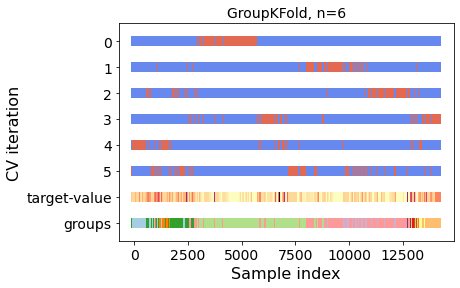

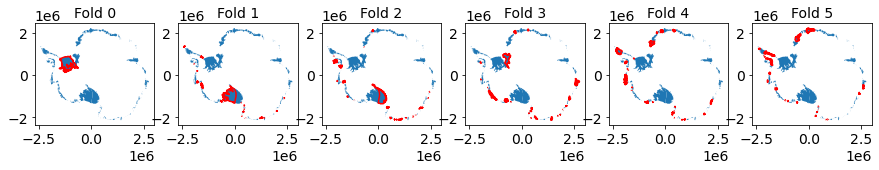

In [24]:

### PLOT FOLDS

target_var = 'dmg' 
input_vars = ['vx','vy']
n_outer = 6
cv_outer = GroupKFold(n_splits=n_outer) # the number of distinct groups has to be >= number of folds (n_splits)

## apply split
cv_outer_folds = [fold for fold in cv_outer.split(data_gdf,groups=spatial_groups)] # list with a tuple for each fold with (train_idx, test_idx)


## Plot group indices per fold
fig, ax = plt.subplots()
plot_cv_indices(cv_outer, data_gdf[input_vars], data_gdf[target_var], spatial_groups, ax, n_outer)
ax.set_title('GroupKFold, n={}'.format(n_outer))


## Plot selected ice shelves (groups) per fold

fig,axs=plt.subplots(1,n_outer,figsize=(15,6))
for fold_num, current_fold in enumerate( cv_outer_folds ):
    train_idx, test_idx = current_fold
    ratio_tr = len(train_idx)/len(data_gdf) * 100
    ratio_tt = len(test_idx)/len(data_gdf) * 100
    print('CV outer split={} fold {} -- training/testing {:.0f}/{:.0f}% of all samples {}/{}'.format(n_outer, fold_num, ratio_tr,ratio_tt, len(train_idx),len(test_idx)))

    # Fill in indices with the training/test groups
    indices = np.array([np.nan] * len(data_gdf))
    indices[test_idx] = 1
    indices[train_idx] = 0

    fold_iceshelves_test = data_gdf.iloc[test_idx][['dmg','geometry']].sjoin(iceshelf_poly_meas)['NAME'].unique()
    ishelf_select = iceshelf_poly_meas.loc[iceshelf_poly_meas['NAME'].isin(fold_iceshelves_test)]

    # Plot selected iceshelves for folds
    ax=axs[fold_num]
    iceshelf_poly_meas.plot(ax=ax)
    ishelf_select.boundary.plot(ax=ax,color='red')
    ax.set_title('Fold {}'.format(fold_num))



In [25]:
''' --------
## Select a single fold, analyse distribution
-----------'''

# select nth outer_fold
nth_fold = 3
train_idx, test_idx = cv_outer_folds[nth_fold]
train_idx #  --> use this set for grid/randomSearchCV to split in train/val set

## Add info to which fold split category (train/test) each px belongs in dataframe
data_gdf['fold_split'] = indices # 1 and 0, replace with text
data_gdf['fold_split'] = np.where(data_gdf['fold_split'] == 1, 'test', 'train')
data_gdf['fold_split'] = data_gdf['fold_split'].astype('category')



In [26]:
data_gdf

,time,x,y,dmg,vx,vy,geometry,iceshelf_index,NAME,Regions,fold_split
59828,2019,-2416000.0,1344000.0,0.042277,-198.132904,-147.554001,POINT (-2416000.000 1344000.000),153,LarsenA,Peninsula,train
60587,2019,-2408000.0,1336000.0,0.039072,-295.896210,-228.818542,POINT (-2408000.000 1336000.000),153,LarsenA,Peninsula,train
60588,2019,-2408000.0,1344000.0,0.037160,-255.343689,-217.392380,POINT (-2408000.000 1344000.000),153,LarsenA,Peninsula,train
60589,2019,-2408000.0,1352000.0,0.042111,-220.038162,-164.115280,POINT (-2408000.000 1352000.000),153,LarsenA,Peninsula,train
61348,2019,-2400000.0,1344000.0,0.042141,-264.443390,-211.985550,POINT (-2400000.000 1344000.000),153,LarsenA,Peninsula,train
...,...,...,...,...,...,...,...,...,...,...,...
549060,2019,2736000.0,-320000.0,0.009276,150.896790,104.109726,POINT (2736000.000 -320000.000),99,Shackleton,East,train
549061,2019,2736000.0,-312000.0,0.009348,133.840057,116.852158,POINT (2736000.000 -312000.000),99,Shackleton,East,train
549062,2019,2736000.0,-304000.0,0.011572,128.556198,136.537827,POINT (2736000.000 -304000.000),99,Shackleton,East,train
549063,2019,2736000.0,-296000.0,0.030126,131.109512,143.758026,POINT (2736000.000 -296000.000),99,Shackleton,East,train


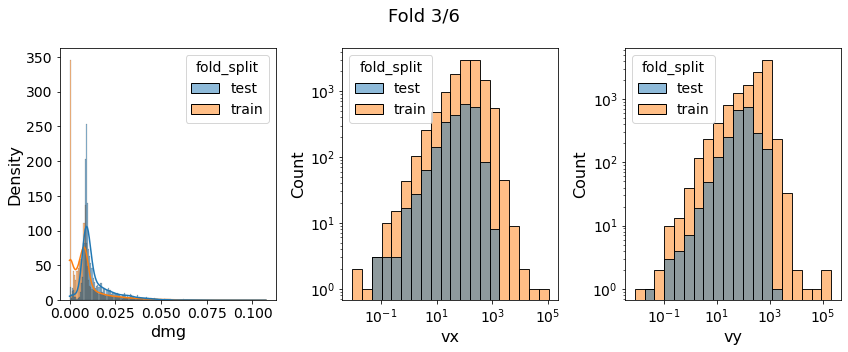

In [27]:

## Plot data distribution
plot_vars = ['dmg','vx','vy']
data_gdf['vx'] = data_gdf['vx'].abs()
data_gdf['vy'] = data_gdf['vy'].abs() ## need to plot absolute velocity if using log scale

fig,axs=plt.subplots(1,len(plot_vars),figsize=(12,5))

k=0; ax=axs[k]
ax = sns.histplot( data_gdf,ax=ax, 
                    x='dmg', hue='fold_split', 
                    stat="density", common_norm=False, # to compare the distribution of subsets that differ substantially in size, use independent density normalization:
                    kde=True)  
k+=1; ax=axs[k]
ax = sns.histplot( data_gdf,ax=ax,  
                    x='vx', hue='fold_split', bins=20,
                    log_scale=[True,True]
                    )
k+=1; ax=axs[k]
ax = sns.histplot( data_gdf,ax=ax, 
                    x='vy', hue='fold_split', bins=20,
                    log_scale=[True,True]
                    )
fig.suptitle('Fold {}/{}'.format(nth_fold,n_outer ))
fig.tight_layout()
    


In [28]:

''' --------
## ## Split datasets, 
Need to furhter split train-set into train/val subsets 
-----------'''

# For selected fold, split train/test                                
fold1_traindata = data_gdf.iloc[train_idx]
fold1_testdata = data_gdf.iloc[test_idx]
fold1_spatialgroups = spatial_groups.iloc[train_idx]
fold1_spatialgroups_test = spatial_groups.iloc[test_idx]

## add spatial metadata to dataframe
fold1_testdata = fold1_testdata.sjoin(iceshelf_poly_meas) # 
fold1_traindata = fold1_traindata.sjoin(iceshelf_poly_meas) 


## .... continue

